## Работа с API

Библиотеки:

* pandas для работы с данными
* matplotlib для визуализации 
* time, datetime для работы со временем и датами
* requests для HTTPS-запросов
* json для работы с содержимым запросов 
* sqlite3 для работы с базой данных SQlite

In [3]:
import requests
import json
from datetime import timedelta, date, datetime
import time
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd

#### Справочник криптовалют: возмем Топ-5 монет по капитализации согласно [CoinMarketCap](https://coinmarketcap.com/)

In [3]:
top_coins = [
    'Bitcoin', 
    'Ethereum', 
    'Tether', 
    'USD Coin', 
    'BNB'
]

#### Создаем небольшую базу данных для хранения результатов

In [4]:
conn = sqlite3.connect('coins_prices')
c = conn.cursor()

c.execute('''
    CREATE TABLE IF NOT EXISTS prices (
          coingecko_id nvarchar(255), 
          price_date date, 
          btc REAL, 
          usd REAL, 
          insert_dttm datetime
    )
''')
conn.commit()

c.execute('''
    SELECT distinct price_date 
    FROM prices
''')
conn.commit()

#### Фиксируем все уже загруженные данные

In [5]:
dates_saved = [
  datetime.strptime(x[0], '%Y-%m-%d %H:%M:%S') for x in c.fetchall()
]

#### Проанализировав документацию, можно понять как формируются ссылки, которые отвечают за определенные данные, создадим функции для этого

In [1]:
def get_simple_coins_list() -> dict:
    """
    Функция возвращает список всех поддерживаемых coingecko криптовалют
    """
    coins_url = (
        'https://api.coingecko.com/api/v3/coins/list?include_platform=false'
    )
    content = requests.get(coins_url)
    return json.loads(content.text)

def get_history(coin: str, date: str) -> dict:
    """
    Функция возвращает историю по монете за дату 
    
    Args:
        coin (str): тикер монеты
        date (str): дата в формате "07-07-2022"
    
    Returns:
        (dict): словарь с данными по цене
    """
    history_url = (
        f'https://api.coingecko.com/api/v3/coins/{coin}/history?date={date}'
    )
    content = requests.get(history_url)
    return json.loads(content.text)

#### Получаем данные по монетам, список всех наимнований

In [4]:
%%time
coins_meta = get_simple_coins_list()

CPU times: user 28.9 ms, sys: 11.8 ms, total: 40.7 ms
Wall time: 817 ms


In [8]:
def parse_coins_id(coins_meta: dict) -> list:
    """
    Функция парсит данные по наименованиям монетам и возвращает только нужные поля
    
    Args:
        coins_meta (dict): словарь всех монет
    Returns:
        (list): с преобразованными данными по монетам
    """
    list_id = []
    for row in coins_meta:
        list_coin = (row['id'], row['symbol'], row['name'])
        list_id.append(list_coin)
    return list_id

#### Генерируем датафрейм из списка всех поддерживаемых __coingecko__ криптовалют

In [9]:
df_coins_all_meta = pd.DataFrame(parse_coins_id(coins_meta), columns = ['id', 'symbol', 'name'])
print(df_coins_all_meta.shape)
df_coins_all_meta.head()

(13107, 3)


,id,symbol,name
0,01coin,zoc,01coin
1,0-5x-long-algorand-token,algohalf,0.5X Long Algorand
2,0-5x-long-altcoin-index-token,althalf,0.5X Long Altcoin Index
3,0-5x-long-ascendex-token-token,asdhalf,0.5X Long AscendEx
4,0-5x-long-bitcoin-cash-token,bchhalf,0.5X Long Bitcoin Cash


Данный датафрейм нам будет нужен для сопоставления нашего списка названий монет и их обозначения (id), которое использует coingecko

#### Из всех криптовалют выбираем только те, что есть в нашем списке

In [10]:
coins_set = df_coins_all_meta.loc[df_coins_all_meta['name'].isin(top_coins)]
coins_set

,id,symbol,name
1553,binancecoin,bnb,BNB
1637,bitcoin,btc,Bitcoin
4225,ethereum,eth,Ethereum
11318,tether,usdt,Tether
11987,usd-coin,usdc,USD Coin


В переменной __coin_set__ - хранится результат пересечения нужных нам монет и общего списка. В нем мы получили внутренние id системы благодаря, которым мы сможем вытащить историю.

#### Генерируем дату начала и весь пул дат, которые нам нужно обработать. Период можно указать произвольный: чем больше, тем дольше будет выгружаться.

In [14]:
DELTA_PERIOD = 14

if dates_saved:
    start_date = max(dates_saved) + timedelta(days=1)
else:
    start_date = date.today() - timedelta(days=DELTA_PERIOD)

end_date = date.today() - timedelta(days=1)
daterange = [x.strftime('%d-%m-%Y') for x in pd.date_range(start_date, end_date)]

In [15]:
import numpy as np

def get_coins_price_set(coins_ids: np.ndarray, daterange: list) -> list:
    """
    Функция парсит данные по наименованиям монетам и возвращает только нужные поля.
    
    Args:
        coins_ids (np.ndarray): массив из тикеров монет
    """
    list_hist = []

    for each_id in coins_ids:
        for i, each_date in enumerate(daterange):
            try:
                print(each_id, f'day {i+1}')
                data = get_history(each_id, each_date)
                btc_price = data['market_data']['current_price']['btc']
                usd_price = data['market_data']['current_price']['usd']
                list_hist.append((each_id, each_date, btc_price, usd_price))
                time.sleep(1.25)
            except Exception as e:
                print(f'Error was occured {e}')
                continue
    return list_hist

Запустим весь код. Это займет некоторое время, так как лимит обращения к веб сервису 50 запросов в секунду. Поэтому мы используем time.sleep, чтобы не перегружать сервис и не вызывать ошибку. 

In [16]:
%%time
print(f"Getting history for {coins_set['id'].nunique()} coins and {DELTA_PERIOD} days")
list_hist = get_coins_price_set(coins_set['id'].unique(), daterange)

Getting history for 5 coins and 14 days
binancecoin day 1
binancecoin day 2
binancecoin day 3
binancecoin day 4
binancecoin day 5
binancecoin day 6
binancecoin day 7
binancecoin day 8
binancecoin day 9
binancecoin day 10
binancecoin day 11
binancecoin day 12
binancecoin day 13
binancecoin day 14
bitcoin day 1
bitcoin day 2
bitcoin day 3
bitcoin day 4
bitcoin day 5
bitcoin day 6
bitcoin day 7
bitcoin day 8
bitcoin day 9
bitcoin day 10
bitcoin day 11
bitcoin day 12
bitcoin day 13
bitcoin day 14
ethereum day 1
ethereum day 2
ethereum day 3
ethereum day 4
ethereum day 5
ethereum day 6
ethereum day 7
ethereum day 8
ethereum day 9
ethereum day 10
ethereum day 11
ethereum day 12
ethereum day 13
ethereum day 14
tether day 1
tether day 2
tether day 3
tether day 4
tether day 5
tether day 6
tether day 7
tether day 8
tether day 9
tether day 10
tether day 11
tether day 12
tether day 13
tether day 14
usd-coin day 1
usd-coin day 2
usd-coin day 3
usd-coin day 4
usd-coin day 5
usd-coin day 6
usd-coin d

#### Отображаем данные внутри датасета как str, для scientific notation

In [17]:
pd.set_option('display.float_format', str)

#### Преобразуем данные:
* Формируем датафрейм из скаченной истории
* Форматируем дату
* Устанавливаем дату загрузки
* Формируем датафрейм
* Форматируем дату данных из БД
* Объединяем датафреймы

In [22]:
set_loaded_history_coins = pd.DataFrame(list_hist, columns=['coingecko_id', 'price_date', 'btc', 'usd']).sort_values('price_date')
set_loaded_history_coins['price_date'] = set_loaded_history_coins['price_date'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y'))
set_loaded_history_coins['insert_dttm'] = datetime.now()

set_history_coins = pd.DataFrame([x for x in c.fetchall()], columns=['coingecko_id', 'price_date', 'btc', 'usd', 'insert_dttm'])
set_history_coins['price_date'] = set_history_coins['price_date'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y')) 

set_all_coins = pd.concat([set_history_coins, set_loaded_history_coins])

#### Формируем датафрейм и записываем скаченную историю в БД

In [23]:
set_all_coins.price_date = set_all_coins['price_date'].astype('datetime64[ns]')
set_loaded_history_coins.to_sql('prices', conn, if_exists='append', index=False)

#### Обработаем данные для выведения графика "Как сильно упала цена монеты относительно BTC"

In [25]:
set_all_coins[['coingecko_id', 'price_date', 'btc', 'usd']].head()

,coingecko_id,price_date,btc,usd
0,binancecoin,2022-07-15,0.01158038218793217,238.36968523101555
28,ethereum,2022-07-15,0.05789913618886284,1191.1308371103116
42,tether,2022-07-15,4.856929171008942e-05,0.9998924467410043
14,bitcoin,2022-07-15,1.0,20574.84059150044
56,usd-coin,2022-07-15,4.865735741574883e-05,1.001560508760777


In [26]:
max_val_btc = set_all_coins.groupby('coingecko_id')['btc'].max()
max_val_btc_df = pd.DataFrame(max_val_btc).rename(columns = {'btc': 'btc_max'})

set_history_coins_merged = pd.merge(
    set_all_coins,
    max_val_btc_df, 
    on='coingecko_id'
)

set_history_coins_merged['btc_norm'] = set_history_coins_merged['btc'] / set_history_coins_merged['btc_max']

avg_score = (
    set_history_coins_merged[['coingecko_id', 'price_date', 'btc_norm']]
    .groupby('coingecko_id')[['btc_norm']].mean()
    .sort_values('btc_norm', ascending = False)
)

bar_test = set_history_coins_merged.loc[set_history_coins_merged.price_date == 
                                        set_history_coins_merged.price_date.max()].sort_values('btc_norm', ascending=False)

#### Визуализируем результат

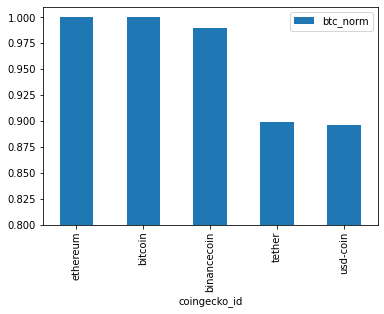

In [27]:
bar_test.plot.bar(x='coingecko_id', y='btc_norm')
plt.ylim(0.8, 1.01)
plt.show()

* Провели нормализацию данных по их максимальному значению за период и поняли насколько они упали относительно него. Получился информативный descriptive анализ.